### Importing Libraries and mounting drive

In [ ]:
!pip install face_recognition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# import face_recognition
import random
import cv2
# import torch
import pywt

# from torch.utils.data import DataLoader

from skimage.filters import gabor_kernel

import dlib
from scipy import ndimage as ndi

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils.vis_utils import plot_model

from keras.layers import Input, Dense, concatenate, Conv2D, MaxPool2D, Dropout, Flatten
from keras.models import Model

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

### All Functions

In [ ]:
def find_biggest_BLOb(BLObs):
    areas = []
    for face in BLObs:
        x1 = face.left() # left point
        y1 = face.top() # top point
        x2 = face.right() # right point
        y2 = face.bottom() # bottom point
        w = abs(x2 - x1)
        h = abs(y2 - y1)
        areas.append(w * h)    
    return areas.index(max(areas))


In [ ]:
def get_face(faces, image):
    if len(faces) > 0:
        face_index = find_biggest_BLOb(faces)
        face = faces[face_index]
    
        x1 = abs(face.left()) # left point
        y1 = face.top() # top point
        x2 = face.right() # right point
        y2 = face.bottom() # bottom point
        w = abs(x2 - x1)
        h = abs(y2 - y1)
        face_crop = image[y1:y1 + h, x1:x1 + w]
    else:
        face_crop = None
        face = None
    return face_crop, face

In [ ]:
def crop_img (image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("/content/drive/MyDrive/Colab Notebooks/shape_predictor_68_face_landmarks.dat")
    
    faces = detector(image)
            
    [face_crop, face] = get_face(faces, image)
        
    if face != None:
        isLandmarkWorking = True
        landmarks = predictor(image=image, box=face)
    else:
        isLandmarkWorking = False
        face_crop = face_recognition.face_locations(image)
        if len(face_crop) > 0:
            x, y, w, h = face_crop[0]
            if h == 0:
                h = 92
            face_crop = image[y:y + h, x:x + w]
        else:
            face_crop = image

    return [face_crop]

In [ ]:
def summer(decomposition):
    keys = ['face']
    HAAR_features = []
    for key in keys:
        cA, (cH, cV, cD) = decomposition[key]
        HAAR_features.append(round(np.sum(cA),1))
        HAAR_features.append(round(np.sum(cH),1))
#         HAAR_features.append(round(np.sum(cV),1))
        HAAR_features.append(round(np.sum(cD),1))
#         HAAR_features.append(np.sum(cA),np.sum(cH),np.sum(cV),np.sum(cD))
    return HAAR_features

In [ ]:
def HAAR_filter(face):
    decompositions = {'face':[]}
    try:
      decompositions['face'] = pywt.dwt2(face,'haar','constant')
    except:
      decompositions['face'] = 1,(1,1,1)
    # decompositions['face'] = pywt.dwt2(face,'haar','constant')
    return decompositions

In [ ]:
def Gabor_filter():
    kernels = []
    angles = [0,22.5,45,67.5,90,112.5,135, 157.5, 180] #determines what orientation kernels respond to
    frequencies = [0.2,0.3,0.4] #determines sensitivity to gradients (lines)

    for theta in angles:
        for frequency in frequencies:
            kernel = np.real(gabor_kernel(frequency, theta=theta))
            kernels.append(kernel)
                             
    return kernels

In [ ]:
def compute_Gabor_features(face, kernels):
    features = []
    
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(face, kernel, mode='wrap')
        features.append((np.sum(filtered)))
    
    return features

In [ ]:
def create_haar_features(folder_path, target): 
    column_names = [str(x) for x in range(31)]
    df = pd.DataFrame(columns=column_names)


    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.jpg'):
                source_file = os.path.join(dirpath, filename)
                image = cv2.imread(source_file, cv2.IMREAD_GRAYSCALE)
                
                [face] = crop_img(image)
          
            
                decompositions = HAAR_filter(face)
                HAAR_features = summer(decompositions)


                features = HAAR_features
    
                
                kernels = Gabor_filter()
                Gabor_features = compute_Gabor_features(face, kernels)
                [features.append(feat) for feat in Gabor_features]
                features = np.append(features,target)

                
                df.loc[len(df), :] = features
                
                
    return [df]

In [ ]:
def face_as_df(folder_path, target):
    column_names = [str(x) for x in range(3601)]
    df = pd.DataFrame(columns=column_names)
    
    counter = 0
    
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.jpg'):
                source_file = os.path.join(dirpath, filename)
                image = cv2.imread(source_file, cv2.IMREAD_GRAYSCALE)
                
                [face] = crop_img(image)

                if len(face) > 0:
                  resized_face = cv2.resize(face, (60, 60))

                else:
                  resized_face = cv2.resize(image, (60, 60))
                
                features = resized_face.flatten()
                
                features = np.append(features,target)
                
                df.loc[len(df), :] = features
                
                
    return [df]

### Creating datasets

In [ ]:
def get_data(mode):
  if mode == 'scratch':
    !unzip /content/drive/MyDrive/development.zip -d /content/drive/MyDrive/
    !unzip /content/drive/MyDrive/evaluation.zip -d /content/drive/MyDrive/
    
    #To get handcrafted features
        #Development data
    df_haar_real = create_haar_features('/content/drive/MyDrive/development/real', 'real')
    df_haar_fake = create_haar_features('/content/drive/MyDrive/development/fake', 'fake')  
    df = pd.concat([df_haar_real, df_haar_fake], axis=0).reset_index(drop=True)
        #Evaluation data
    test_haar_real = create_haar_features('/content/drive/MyDrive/evaluation/real', 'real')
    test_haar_fake = create_haar_features('/content/drive/MyDrive/evaluation/fake', 'fake')
    df_test = pd.concat([test_haar_real, test_haar_fake], axis=0).reset_index(drop=True)

    #To get face image for CNN features
        #Development data
    df_face_real = face_as_df('/content/drive/MyDrive/development/real', 'real')
    df_face_fake = face_as_df('/content/drive/MyDrive/development/fake', 'fake')
    df_face = pd.concat([df_face_real, df_face_fake], axis=0).reset_index(drop=True)  
        #Evaluation data
    test_face_real = face_as_df('/content/drive/MyDrive/evaluation/real', 'real')
    test_face_fake = face_as_df('/content/drive/MyDrive/evaluation/fake', 'fake')
    df_face_test = pd.concat([test_face_real, test_face_fake], axis=0).reset_index(drop=True)

    test_face_real = face_as_df('/content/drive/MyDrive/Celeb_evaluation/real', 'real')
    test_face_fake = face_as_df('/content/drive/MyDrive/Celeb_evaluation/fake', 'fake')
    df_face_test = pd.concat([test_face_real, test_face_fake], axis=0).reset_index(drop=True)

  else:
    #To get handcrafted features
    df = pd.read_csv('/content/drive/MyDrive/df_unshuffled.csv')
    df_test = pd.read_csv('/content/drive/MyDrive/df_test_unshuffled.csv') 

    df = df.drop(df.columns[0],axis=1) #To drop index column added 
    df_test = df_test.drop(df_test.columns[0],axis=1) #To drop index column added 

    #To get face image for CNN features
    df_face = pd.read_csv('/content/drive/MyDrive/df_face_unshuffled.csv')
    df_face_test = pd.read_csv('/content/drive/MyDrive/df_face_test_unshuffled.csv') 

    df_face = df_face.drop(df_face.columns[0],axis=1) #To drop index column added 
    df_face_test = df_face_test.drop(df_face_test.columns[0],axis=1) #To drop index column added 


  return [df, df_face, df_test, df_face_test]

In [ ]:
mode = 'from_df'
[df, df_face, df_test, df_face_test] = get_data(mode)

### Preprocessing & feature extraction

##### Processing Face Image and resizing for CNN

In [ ]:
#Mapping from Real and Fake to 0 and 1
df_face['3600'] = df_face['3600'].map({'real': 0, 'fake': 1}) #Development
df_face_test['3600'] = df_face_test['3600'].map({'real': 0, 'fake': 1}) #Evaluation

In [ ]:
#Obtaining target classes
face_train_labels = df_face['3600'] #Development
face_test_labels = df_face_test['3600'] #Evaluation

In [ ]:
#One hot encoding of target classes
face_train_labels_one_hot = keras.utils.to_categorical(face_train_labels, 2) #Development
face_test_labels_one_hot = keras.utils.to_categorical(face_test_labels, 2) #Evaluation

In [ ]:
#Obtaining features / attributes
face_train_data = df_face.drop(columns=['3600']) #Development
face_test_data = df_face_test.drop(columns=['3600']) #Evaluation

In [ ]:
#Converting features into images of size (60x60) by reshaping
face_x_train = np.array([np.array(face_train_data.loc[x,:]).reshape((60, 60)) for x in range(face_train_data.shape[0])])
face_x_test = np.array([np.array(face_test_data.loc[x,:]).reshape((60, 60)) for x in range(face_test_data.shape[0])])

##### Processing Handcrafted Feature obtained Haar and Gabor filters

In [ ]:
#Mapping from Real and Fake to 0 and 1
df['30'] = df['30'].map({'real': 0, 'fake': 1})
df_test['30'] = df_test['30'].map({'real': 0, 'fake': 1})

In [ ]:
#Obtaining target classes
train_labels = df['30']
test_labels = df_test['30']

In [ ]:
#One hot encoding of target classes
train_labels_one_hot = keras.utils.to_categorical(train_labels, 2)
test_labels_one_hot = keras.utils.to_categorical(test_labels, 2)

In [ ]:
#Obtaining features / attributes
train_data = df.drop(df.columns[-1],axis=1)
test_data = df_test.drop(df_test.columns[-1],axis=1)

### Model Configuration

In [ ]:
K.clear_session()

# Creating the first input layer ==> of face images for CNN
input_1 = Input(shape=(60,60,1))

# Creating the second input layer ==> of handcrafted features to be added to CNN features
input_2 = Input(shape=(30,))

# Backbone CNN feature extractor model 
conv_1 = Conv2D(32, kernel_size=3, activation='relu')(input_1)
max_1 = MaxPool2D(pool_size=2, strides=2)(conv_1)
drop_1 = Dropout(rate=0.25)(max_1)

conv_2 = Conv2D(64, kernel_size=3, activation='relu')(drop_1)
max_2 = MaxPool2D(pool_size=2, strides=2)(conv_2)
drop_2 = Dropout(rate=0.25)(max_2)

#Flattening CNN features
flattened = Flatten()(drop_2)

# Concatenate the output of the first sub-model with the second input layer ==> Concatenating CNN features with handcrafted features
concatenated = concatenate([flattened, input_2])

# Creating fully connected classsifier
dense_1 = Dense(256, activation='relu')(flattened)
drop_3 = Dropout(rate=0.25)(dense_1)
dense_2 = Dense(2, activation='sigmoid')(drop_3)

In [ ]:
# Defining the full model with both inputs
model = Model(inputs=[input_1, input_2], outputs=dense_2)

print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.e-3), loss='binary_crossentropy', metrics=['acc'])

### Model Training

In [ ]:
nepochs = 50

history = model.fit([np.asarray(face_x_train).astype('float32'),np.asarray(train_data).astype('float32')], 
                    train_labels_one_hot, epochs=nepochs, 
                    validation_data=None, batch_size=5)

In [ ]:
model.save('task1_model.h5')

### Importing the model

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/task1_model.h5')

### Evaluating model performance by comparing predictions to ground truth

##### Obtaining Groundtruth

In [ ]:
def get_ground_truth():
  zeros = np.zeros(face_test_labels.value_counts()[0]).astype(int).tolist()
  ones = np.ones(face_test_labels.value_counts()[1]).astype(int).tolist()

  y_true = zeros + ones
  return y_true

In [ ]:
y_true = get_ground_truth()

##### Obtaining Predictions

In [ ]:
def get_result():
  pred = model.predict([np.asarray(face_x_test).astype('float32'), np.asarray(test_data).astype('float32')])
  result = []
  for i in range(len(pred)):
    if pred[i][0] > pred[i][1]:
      result.append(0)
    else:
      result.append(1)

  return result

In [ ]:
y_pred = get_result()

7/7 [==============================] - 8s 15ms/step


##### Confusion Matrix

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:
[[99 11]
 [ 4 96]]


##### Prediction Accuracy

In [ ]:
print(f'Accuracy is: {accuracy_score(y_true, y_pred)}')

Accuracy is: 0.9285714285714286


##### Plotting Curves

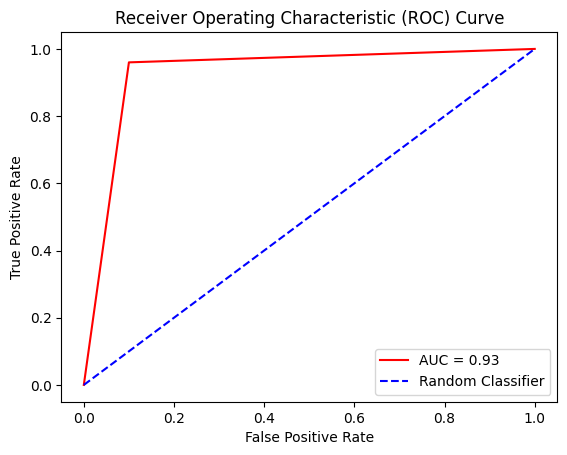

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}',color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()